# Import RFM data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')


In [37]:
df_RFM = pd.read_csv('df_RFM.csv')
df_RFM.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,2193,91,27,361.45,3,4,4,344,11
1,1793,26,25,345.10,4,4,4,444,12
2,3289,4,29,334.15,4,4,4,444,12
3,2433,3,30,316.81,4,4,4,444,12
4,2743,142,17,312.46,2,4,4,244,10


# Manual Segmentation

In [38]:
def rfm_level(df):
    if df['RFM_Score'] == 12:
        return 'CHAMPIONS'
    elif df['R'] == 4 and df['F'] <= 2 and df['M'] >= 2:
        return 'NEW-POTENTIAL'
    elif df['R'] == 3 and df['M'] == 4:
        return 'NEED ATTENTION'
    elif df['R'] <= 2 and df['M'] >= 3:
        return 'LOST-HIGH SPEND'
    # elif df['R'] <= 2 and df['F'] >= 3 and df['M'] < 4:
    #     return 'LOST-LOYAL'
    elif df['R'] == 4:
        return 'ACTIVE'
    elif df['R'] == 2:
        return 'AT RISK'
    elif df['R'] == 1:
        return 'OTHER LOST'
    else:
        return 'REGULARS'
    




In [39]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,2193,91,27,361.45,3,4,4,344,11,NEED ATTENTION
1,1793,26,25,345.10,4,4,4,444,12,CHAMPIONS
2,3289,4,29,334.15,4,4,4,444,12,CHAMPIONS
3,2433,3,30,316.81,4,4,4,444,12,CHAMPIONS
4,2743,142,17,312.46,2,4,4,244,10,LOST-HIGH SPEND


In [40]:
df_RFM['RFM_Level'].value_counts()

RFM_Level
OTHER LOST         728
LOST-HIGH SPEND    717
REGULARS           675
ACTIVE             513
AT RISK            504
NEED ATTENTION     299
CHAMPIONS          288
NEW-POTENTIAL      174
Name: count, dtype: int64

In [41]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,ACTIVE,27.0,11.0,79.0,513,13.16
1,AT RISK,206.0,7.0,44.0,504,12.93
2,CHAMPIONS,29.0,18.0,176.0,288,7.39
3,LOST-HIGH SPEND,263.0,12.0,118.0,717,18.39
4,NEED ATTENTION,97.0,16.0,163.0,299,7.67
5,NEW-POTENTIAL,29.0,7.0,76.0,174,4.46
6,OTHER LOST,435.0,5.0,36.0,728,18.68
7,REGULARS,99.0,9.0,66.0,675,17.32


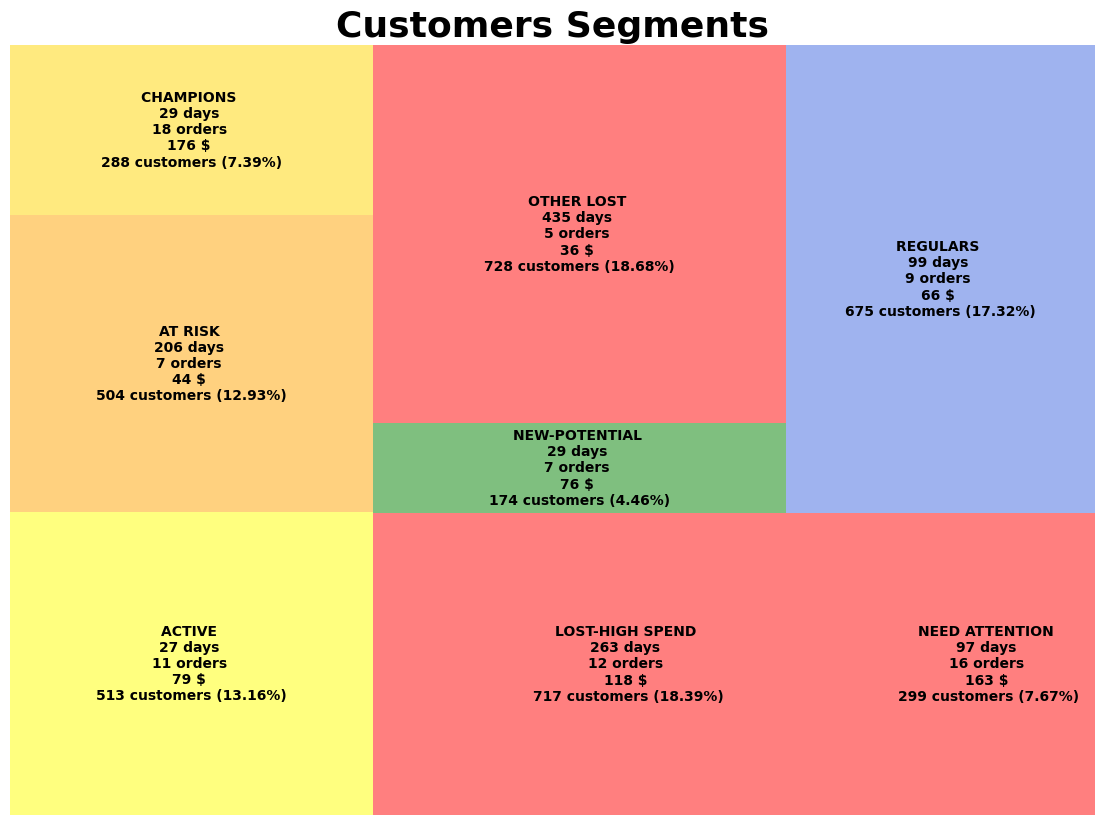

In [42]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {
    'ACTIVE': 'yellow',
    'REGULARS': 'royalblue',
    'ABOUT TO SLEEP': 'cyan',
    'LOST-HIGH SPEND': 'red',
    'LOST-LOYAL': 'red',
    'NEED ATTENTION': 'red',
    'NEW-POTENTIAL': 'green',
    'CHAMPIONS': 'gold',
    'AT RISK': 'orange',
    'OTHER LOST': 'red'
}

colors = [colors_dict.get(seg, 'gray') for seg in rfm_agg['RFM_Level']]


squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':10,'weight':'bold', 'fontname':"sans serif"},
              color=colors,
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('outputs/RFM Segments.png')
plt.show()

In [43]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="FrequencyMean", size="MonetaryMean", color="RFM_Level",
           hover_name="RFM_Level", size_max = 60) 
fig.show()

# KMeans
## Kmeans clusters with the Elbow Method

In [44]:
df = df_RFM[['Recency','Frequency','Monetary']]
df.head()

,Recency,Frequency,Monetary
0,91,27,361.45
1,26,25,345.10
2,4,29,334.15
3,3,30,316.81
4,142,17,312.46


In [45]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

sse

{1: 111700643.2836853,
 2: 39483368.43008065,
 3: 24293553.20339857,
 4: 19344547.194716286,
 5: 13817219.219360083,
 6: 11353396.200591315,
 7: 9929436.714831557,
 8: 8549174.794801237,
 9: 7735265.990922536,
 10: 7020355.261333581,
 11: 6231718.487218884,
 12: 5748112.470083131,
 13: 5357470.579977257,
 14: 4930219.160335893,
 15: 4692235.712145971,
 16: 4397401.575796136,
 17: 4135068.634098146,
 18: 3908938.2837320776,
 19: 3717194.889494166}

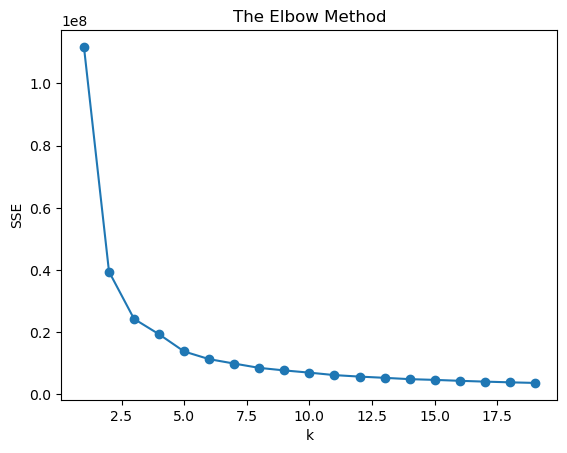

In [46]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [47]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df)
model.labels_.shape

(3898,)

In [48]:
df["Cluster"] = model.labels_
df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        192.25      9.44    78.24  1075
1         55.47      9.59    71.31  1207
2         63.78     17.09   175.39   604
3        560.38      4.43    37.16   300
4        353.08      7.23    61.33   712

In [49]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,192.0,9.0,78.0,1075,27.58
1,Cluster 1,55.0,10.0,71.0,1207,30.96
2,Cluster 2,64.0,17.0,175.0,604,15.50
3,Cluster 3,560.0,4.0,37.0,300,7.70
4,Cluster 4,353.0,7.0,61.0,712,18.27


In [50]:
cluster_names = {
    'Cluster 0': 'POTENTIAL',     # Không hoạt động lâu (192 ngày), giá trị trung bình (78)
    'Cluster 1': 'ACTIVE',        # Hoạt động gần đây nhất (55 ngày), giá trị ổn định (71)
    'Cluster 2': 'VIP',           # Hoạt động gần (64 ngày), tần suất cao (17), giá trị cao (175)
    'Cluster 3': 'LOST',          # Không hoạt động rất lâu (560 ngày), giá trị thấp (37)
    'Cluster 4': 'INACTIVE'       # Không hoạt động lâu (353 ngày), giá trị thấp (61)
}

# Replace cluster names
rfm_agg2['Cluster'] = rfm_agg2['Cluster'].map(cluster_names)

# Show updated results
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,POTENTIAL,192.0,9.0,78.0,1075,27.58
1,ACTIVE,55.0,10.0,71.0,1207,30.96
2,VIP,64.0,17.0,175.0,604,15.50
3,LOST,560.0,4.0,37.0,300,7.70
4,INACTIVE,353.0,7.0,61.0,712,18.27


Kết quả phân cụm có 5 cụm như sau:

| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| POTENTIAL | 1075 | Phân khúc khách hàng lớn thứ hai (27.58%), tần suất giao dịch trung bình (9.0), chi tiêu trung bình (78.0), không hoạt động gần đây (192 ngày). Đây là nhóm khách hàng tiềm năng cần được kích hoạt lại. |
| ACTIVE | 1207 | Phân khúc lớn nhất (30.96%), tần suất giao dịch khá (10.0), chi tiêu trung bình (71.0), hoạt động rất gần đây (55 ngày). Đây là nhóm khách hàng ổn định và đang tích cực. |
| VIP | 604 | Phân khúc trung bình (15.50%), tần suất giao dịch cao nhất (17.0), chi tiêu cao nhất (175.0), hoạt động gần đây (64 ngày). Đây là nhóm khách hàng cao cấp, trung thành và có giá trị lớn nhất. |
| LOST | 300 | Phân khúc nhỏ nhất (7.70%), tần suất giao dịch thấp nhất (4.0), chi tiêu thấp nhất (37.0), không hoạt động rất lâu (560 ngày). Đây là nhóm khách hàng đã rời bỏ. |
| INACTIVE | 712 | Phân khúc trung bình (18.27%), tần suất giao dịch thấp (7.0), chi tiêu thấp (61.0), không hoạt động lâu (353 ngày). Đây là nhóm khách hàng đang giảm dần sự gắn kết. |

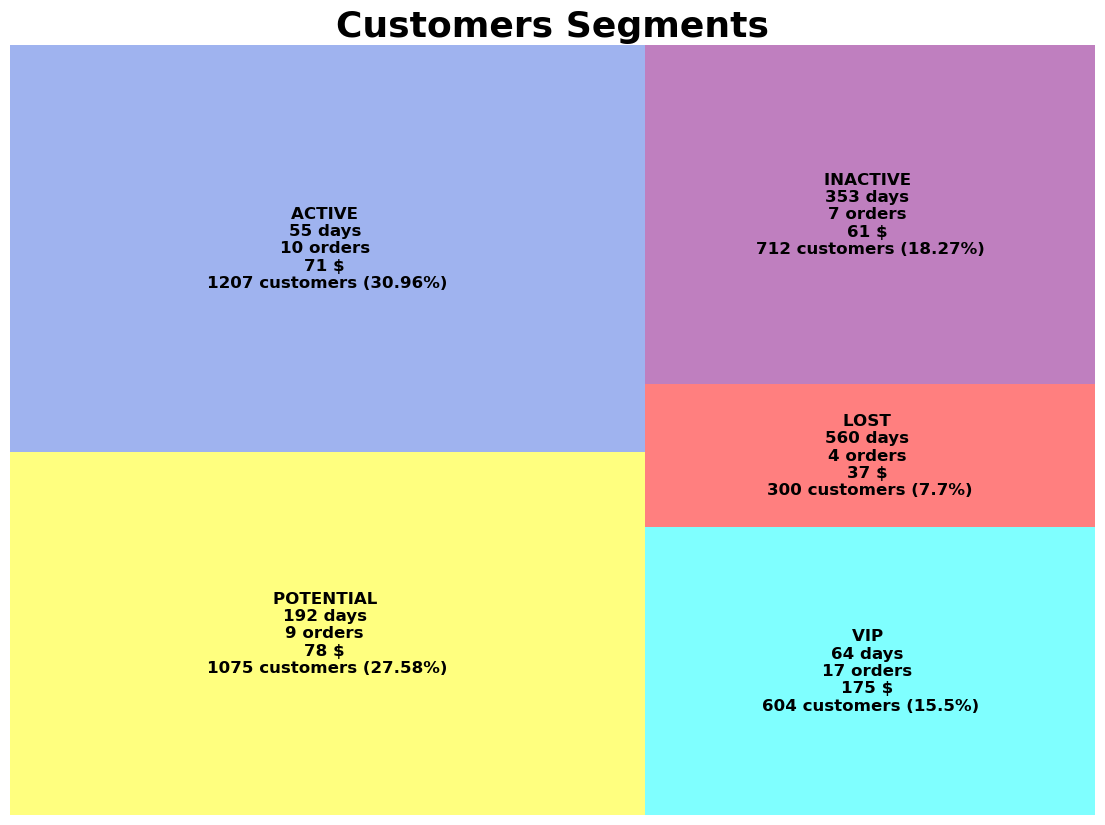

In [51]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

# Define color mapping
colors_dict2 = {'POTENTIAL':'yellow','ACTIVE':'royalblue', 'VIP':'cyan',
               'LOST':'red', 'INACTIVE':'purple'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('outputs/Kmeans Unsupervised Segments.png')
plt.show()

In [52]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100, color_discrete_map=colors_dict2)
fig.show()

# Hierarchical Clustering

In [53]:
df_RFM = df_RFM[['Member_number', 'Recency', 'Frequency', 'Monetary']]
df_RFM.head()

,Member_number,Recency,Frequency,Monetary
0,2193,91,27,361.45
1,1793,26,25,345.10
2,3289,4,29,334.15
3,2433,3,30,316.81
4,2743,142,17,312.46


## Check Outliers

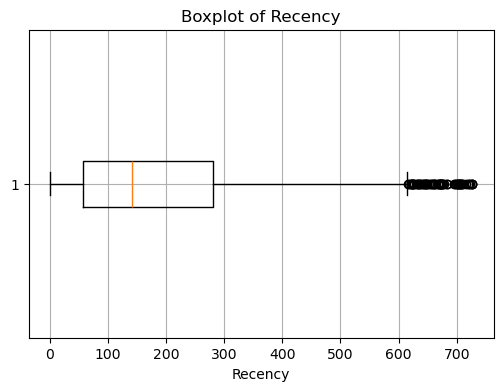

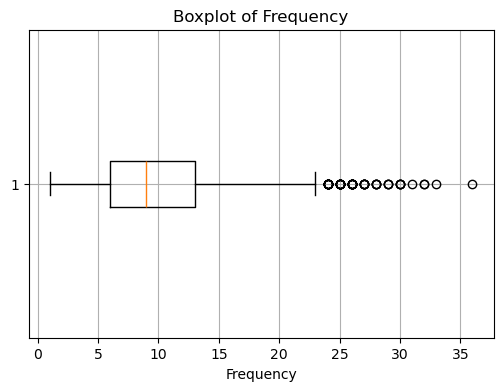

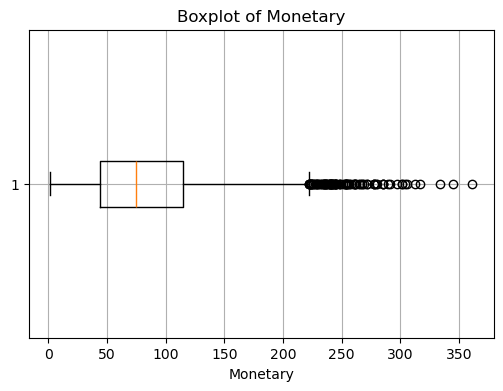

In [54]:
def plot_box(df, col):
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()
    
plot_box(df_RFM, 'Recency')
plot_box(df_RFM, 'Frequency')
plot_box(df_RFM, 'Monetary')



In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_RFM[['Recency', 'Frequency', 'Monetary']]
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
scaled_df.describe() # SCALED

,Recency,Frequency,Monetary
count,3898.000000,3.898000e+03,3898.000000
mean,0.000000,1.166617e-16,0.000000
std,1.000128,1.000128e+00,1.000128
min,-1.173925,-1.685715e+00,-1.514203
25%,-0.817435,-7.367912e-01,-0.746777
50%,-0.292080,-1.674371e-01,-0.183270
75%,0.577255,5.917018e-01,0.543498
max,3.372889,4.956750e+00,4.997257


## Plot the dendrogram

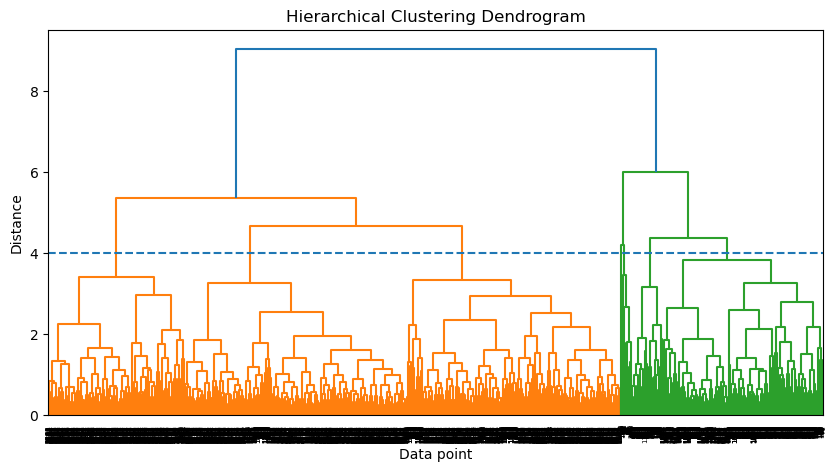

In [56]:
Z = linkage(scaled_df, method='complete') # Khoảng cách giữa hai điểm xa nhất của hai cụm.
# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=scaled_df.index.tolist())  # Use labels from DataFrame index
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(4, linestyle='--')
plt.xlabel('Data point')
plt.ylabel('Distance')
plt.show()

## Clustering

In [64]:
from scipy.cluster.hierarchy import fcluster

# Cắt thành 6 cụm 
cluster_labels = fcluster(Z, t=6, criterion='maxclust')

# Thêm vào DataFrame để dễ xem
scaled_df['Cluster'] = cluster_labels
scaled_df.columns = ['Recency_scaled','Frequency_scaled', 'Monetary_scaled', 'Cluster' ]

scaled_df.head()


,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,-0.604791,3.248688,4.997257,4
1,-1.011315,2.869118,4.701815,4
2,-1.148908,3.628257,4.503951,4
3,-1.155162,3.818042,4.190620,4
4,-0.285826,1.350841,4.112016,4


In [65]:
scaled_df.groupby('Cluster')['Recency_scaled'].count()

Cluster
1     687
2    1117
3    1077
4      55
5     155
6     807
Name: Recency_scaled, dtype: int64

In [66]:
df = pd.concat([df_RFM, scaled_df],axis=1)
df.head()

,Member_number,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,2193,91,27,361.45,-0.604791,3.248688,4.997257,4
1,1793,26,25,345.10,-1.011315,2.869118,4.701815,4
2,3289,4,29,334.15,-1.148908,3.628257,4.503951,4
3,2433,3,30,316.81,-1.155162,3.818042,4.190620,4
4,2743,142,17,312.46,-0.285826,1.350841,4.112016,4


In [67]:
mean_values = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

#calculate Count
count_values = df.groupby('Cluster')['Monetary'].count()

rfm_agg = mean_values.round(0)
rfm_agg['Monetary_count'] = count_values
rfm_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)


rfm_agg = rfm_agg.reset_index()
rfm_agg

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,1,440.0,4.0,34.0,687,17.62
1,2,75.0,7.0,60.0,1117,28.66
2,3,236.0,10.0,79.0,1077,27.63
3,4,74.0,24.0,268.0,55,1.41
4,5,82.0,22.0,178.0,155,3.98
5,6,92.0,15.0,140.0,807,20.70


In [68]:
# name for each cluster
cluster_names = {
    1.0: "Lost",
    2.0: "Regular Customers",
    3.0: "About to Sleep",
    4.0: "Champions",
    5.0: "Loyal High Spenders",
    6.0: "Pay Attention"
}

rfm_agg['Segment'] = rfm_agg['Cluster'].map(cluster_names)
rfm_agg

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent,Segment
0,1,440.0,4.0,34.0,687,17.62,Lost
1,2,75.0,7.0,60.0,1117,28.66,Regular Customers
2,3,236.0,10.0,79.0,1077,27.63,About to Sleep
3,4,74.0,24.0,268.0,55,1.41,Champions
4,5,82.0,22.0,178.0,155,3.98,Loyal High Spenders
5,6,92.0,15.0,140.0,807,20.70,Pay Attention


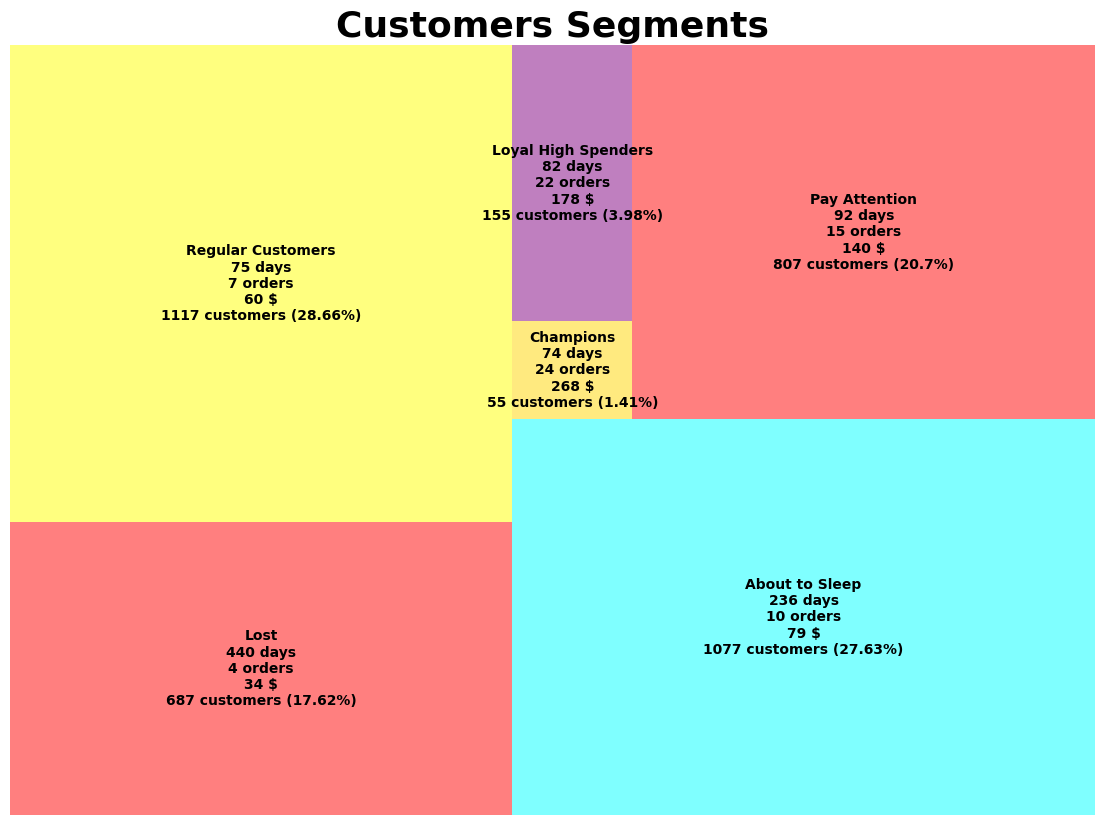

In [71]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'Regular Customers':'yellow', 'About to Sleep':'cyan',
               'Lost':'red', 'Loyal High Spenders':'purple', 'Pay Attention':'red', 'Champions':'gold'}

colors = [colors_dict.get(seg, 'gray') for seg in rfm_agg['Segment']]

# squarify.plot(sizes=rfm_agg['Count'],
#               text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
#               color=colors_dict.values(),
#               label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
#                       for i in range(0, len(rfm_agg))], alpha=0.5 )


squarify.plot(
    sizes=rfm_agg['Count'],
    text_kwargs={'fontsize': 10, 'weight': 'bold', 'fontname': "sans serif"},
    color=colors,
    label=[
        '{}\n{:.0f} days\n{:.0f} orders\n{:.0f} $\n{:.0f} customers ({}%)'.format(
            rfm_agg.iloc[i]['Segment'],
            rfm_agg.iloc[i]['RecencyMean'],
            rfm_agg.iloc[i]['FrequencyMean'],
            rfm_agg.iloc[i]['MonetaryMean'],
            rfm_agg.iloc[i]['Count'],
            rfm_agg.iloc[i]['Percent']
        ) for i in range(len(rfm_agg))
    ],
    alpha=0.5
)



plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('outputs/HC_Segments.png')
plt.show()

In [72]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Segment", size_max = 60) 
fig.show()

#### Đánh giá và so sánh 3 phương pháp phân cụm:

1. Manual Segmentation (Phân cụm thủ công):
- Ưu điểm:
  - Dễ hiểu và giải thích
  - Có thể tùy chỉnh ngưỡng theo domain knowledge
  - Kiểm soát được số lượng và đặc điểm của từng cụm
- Nhược điểm:
  - Chủ quan, phụ thuộc vào kinh nghiệm người phân tích
  - Có thể bỏ sót patterns phức tạp
  - Khó scale với dữ liệu lớn

2. K-means:
- Ưu điểm:
  - Tự động tìm các cụm tối ưu
  - Nhanh và hiệu quả với dữ liệu lớn
  - Elbow method giúp chọn số cụm k phù hợp
- Nhược điểm:
  - Nhạy cảm với outliers
  - Cần xác định trước số cụm k
  - Có thể bị ảnh hưởng bởi điểm khởi tạo

3. Hierarchical Clustering:
- Ưu điểm:
  - Không cần xác định số cụm trước
  - Cho thấy mối quan hệ phân cấp giữa các cụm
  - Ít nhạy cảm với outliers hơn K-means
- Nhược điểm:
  - Chậm hơn K-means với dữ liệu lớn
  - Khó scale
  - Dendrogram có thể phức tạp khi có nhiều dữ liệu

Khuyến nghị:
- Với dataset này, K-means cho kết quả tốt nhất vì:
  - Số lượng cụm phù hợp (4-5 cụm)
  - Dữ liệu không quá lớn
  - Các cụm tương đối rõ ràng và có ý nghĩa kinh doanh

=> Dựa trên đặc điểm của từng nhóm khách hàng, chiến lược sẽ là:

1. Nhóm VIP (604 khách hàng - 15.50%):
- Chương trình loyalty rewards cao cấp
- Ưu đãi độc quyền và preview sản phẩm mới
- Dịch vụ chăm sóc khách hàng VIP
- Tặng quà sinh nhật/ngày đặc biệt
- Mời tham gia các sự kiện exclusive
2. Nhóm ACTIVE (1,207 khách hàng - 30.96%):
- Chương trình tích điểm hấp dẫn
- Cross-selling và up-selling
- Giới thiệu sản phẩm mới
- Khuyến mãi theo sở thích mua sắm
- Mời tham gia membership program
3. Nhóm POTENTIAL (1,075 khách hàng - 27.58%):
- Gửi mã giảm giá để kích hoạt lại
- Email marketing với nội dung phù hợp
- Giới thiệu sản phẩm bestseller
- Chương trình "Welcome Back"
- Khảo sát để hiểu nhu cầu
4. Nhóm INACTIVE (712 khách hàng - 18.27%):
- Chiến dịch re-engagement mạnh
- Ưu đãi đặc biệt để kích hoạt lại
- Nhắc nhở về thương hiệu
- Chương trình win-back
- Khảo sát lý do không hoạt động
5. Nhóm LOST (300 khách hàng - 7.70%):
- Chiến dịch win-back với ưu đãi lớn
- Email marketing định kỳ
- Giới thiệu những thay đổi tích cực
- Chương trình "We Miss You"
- Phân tích nguyên nhân để cải thiện dịch vụ

Các chiến lược chung:
- Cá nhân hóa marketing cho từng nhóm
- Theo dõi và đánh giá hiệu quả định kỳ
- Điều chỉnh chiến lược dựa trên phản hồi
- Tối ưu hóa chi phí marketing theo ROI
- Mục tiêu chuyển đổi khách hàng lên nhóm cao hơn